## Redemption Decay Functions for Reconciliation Estimation

DATASET CONSTRUCTION INFORMATION


This file describes the creation of the initial dataset used to model coupon redemption for Bayer.
The process was done in Alteryx.
Monthly finance reports were provided by Bayer. Each report contained a list of coupons, issue dates,
and redemption numbers. The reports were combined into one large dataset. Only coupons with data
greater than 30 days since issue were included. Three variables, two final and one intermediate, were created.

1. Sum_PERIOD-QTY: contained the sum total of redemptions for each coupon for all periods.
2. Total_Dist_Percent: each period's redemption per coupon divided by the Sum-Period-QTY.
3. Days_Since_Issue: calculated the number of days since coupon issue.

Variables 2 and 3 were used in the Python program.

NOTE: the data provided was monthly. This prevented modeling the first few weeks of any given coupon, meaning coupon forecasting
is only possible after 30 days. Also, after filtering criteria, some coupon types did not have enough samples for accurate modeling,
and were either grouped together by similarity or defaulted to Budget Cost Life.

In [192]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit as cf

In [193]:
def func(x, a, b):
    """
    This function defines the formula
    That we are optimizing, note that since
    The exponential function (non-normalized)
    "Has two parameters" of interest
    :param x: Percentage completed redemption in one period
    :param a: constant coefficient
    :param b: coefficient for x in the exponent of e
    :return: returns a and b, the best estimates for the curve
    """
    return a * np.exp(-b * (x))

In [194]:
def r_squared(x, y, a, b):
    """
    Calculates r-squared, accurate for fitting best fit line
    :param x: x observations
    :param y: y observations
    :param a: coefficient estimate returned from func
    :param b: coefficient estimate returned from func
    :return: r-squared calculation and printout
    """
    res = y - func(x, a, b)
    ss_r = np.sum(res ** 2)
    ss_tot = np.sum((y - np.mean(y) ** 2))
    r_sq = np.round((1 - (ss_r / ss_tot)), 4)
    print(f'R^2 = {r_sq}')
    print(f'Curve Formula: y={a}*exp^(-{b}*(x)')

In [195]:
def plot_curve(x, y, a, b):
    """
    Converts the existing x and y data and the
    best fit curve parameters a and b to create
    a plot
    :param x:
    :param y:
    :param a:
    :param b:
    :return:
    """
    x_est = np.arange(min(x), max(x))
    y_curve = a*np.exp(-b*x_est)
    plt.figure(figsize=(8,8))
    plt.scatter(x, y, s=12)
    plt.plot(x_est, y_curve, '--', color='red')
    plt.show()

In [196]:
def output(x, y, p0):
    """
    This combines all the functions and
    creates the plot, formula for estimates
    and r-squared
    :param x: x data
    :param y: y data
    :param p0: interval in which the curve-fitting
    function begins its search
    :return: plot of data against estimate, model formula
    estimate, and r-squared
    """
    popt, pcov = cf(func, x, y, p0)
    a = np.round(popt[0], 5)
    b = np.round(popt[1], 5)
    r_squared(x, y, a, b)
    plot_curve(x, y, a, b)
    return a, b

In [197]:
# Load Bayer Curves
# Data has media type to break into appropriate groups and run curves

all_coupons = pd.read_csv('C:/Users/norri/Desktop/Bayer/Bayer_Curves.csv')
p0 = [1.0, .05]

Sunday FSI R^2 & Fit Chart
R^2 = 0.92
Curve Formula: y=0.10092*exp^(-0.00205*(x)


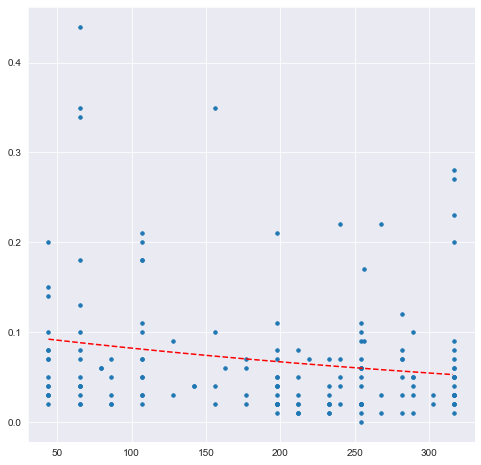

In [198]:
#Sunday FSI Curve, creates subset based on media type (or coupon type)
sun_fsi = all_coupons[all_coupons["Media_Type"] == "Sunday Fsi"]
np_sun_fsi = sun_fsi[['Time_Since_Issue', 'Total_Dist_Percent']].to_numpy(dtype=float)

# Takes the subset by media type and reduces it into a numpy array
# containing the Time Since Issue and Total Distribution Percent data
x = np_sun_fsi[:, 0]
y = np_sun_fsi[:, 1]

# Provides plots and estimates
print('Sunday FSI R^2 & Fit Chart')
a, b = output(x, y, p0)

Paperless R^2 & Fit Chart
R^2 = 0.4065
Curve Formula: y=1.05539*exp^(-0.00136*(x)


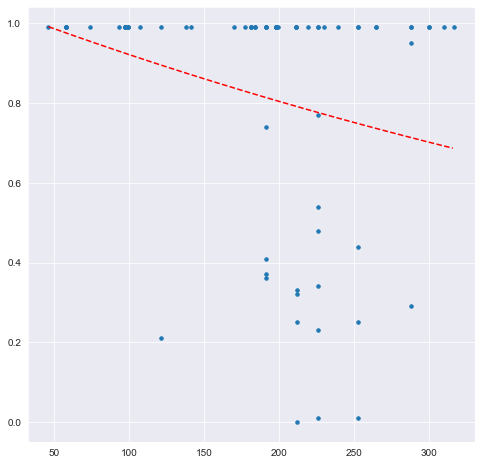

In [199]:
#@title
# Paperless Curve
paperless = all_coupons[all_coupons["Media_Type"] == "Paperless"]
np_paperless = paperless[['Time_Since_Issue',
                          'Total_Dist_Percent']].to_numpy(dtype=float)

x = np_paperless[:, 0]
y = np_paperless[:, 1]

print('Paperless R^2 & Fit Chart')
a, b = output(x, y, p0)

Paperless + Print Group R^2 & Fit Chart
R^2 = 0.2947
Curve Formula: y=0.80896*exp^(--0.00024*(x)


C:\Users\norri\AppData\Local\Temp\ipykernel_1748\1522368043.py:12: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x))


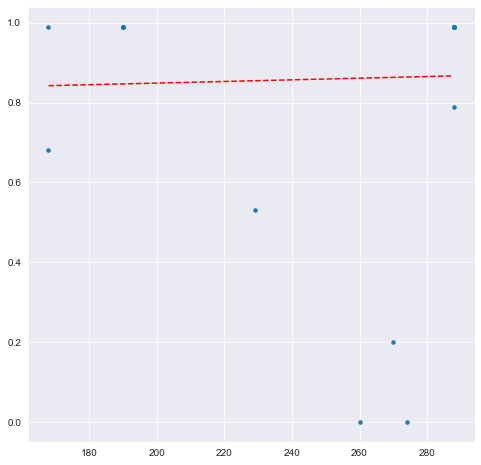

In [200]:
#@title
# Paperless + Print At Home, Print at Home, Paperless + Print at Home Curve

paper_print = all_coupons[all_coupons["Media_Type"].isin(["Paperless + Print at Home",
                                                          "Print At Home",
                                                          "Paperless + Print at Home + Handout"])]

np_paper_print = paper_print[['Time_Since_Issue', 'Total_Dist_Percent']].to_numpy(dtype=float)

x = np_paper_print[:, 0]
y = np_paper_print[:, 1]

print('Paperless + Print Group R^2 & Fit Chart')
a, b = output(x, y, p0)

Handout Group R^2 & Fit Chart
R^2 = 0.3067
Curve Formula: y=0.91167*exp^(-0.00036*(x)


C:\Users\norri\AppData\Local\Temp\ipykernel_1748\1522368043.py:12: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x))


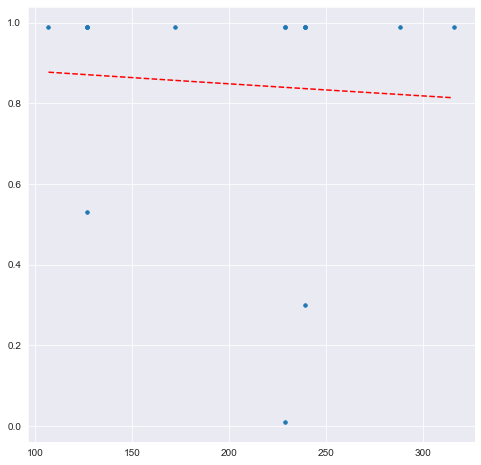

In [201]:
#@title
# HANDOUT, HANDOUT IN-STORE, HANDOUT IN-STORE DISPLAY, HANDOUT IN-STORE TEARPAD,
# HANDOUT SHELF DISPENSER, HANDOUT WITH SAMPLE, INSTANT ON-PACK,
# INSTANT ON-PACK FACTORY APPLIED, ON-PACK

handout = all_coupons[all_coupons["Media_Type"].
isin(["Handout", "Handout In-Store",
      "Handout In-Store Display",
      "Handout In-Store Tearpad",
      "Handout Shelf Dispenser",
      "Handout With Samole", "Instant On-Pack",
      "On-Pack"])]

np_handout = handout[['Time_Since_Issue',
                      'Total_Dist_Percent']].to_numpy(dtype=float)

x = np_handout[:, 0]
y = np_handout[:, 1]

print('Handout Group R^2 & Fit Chart')
a, b = output(x, y, p0)

In [202]:
# #@title
# # All Other: MISCELLANEOUS MEDIA, DIRECT MAIL, DIRECT MAIL SOLO
#
# misc = all_coupons[all_coupons["Media_Type"].isin(["Miscellaneous Media",
#                                                     "Direct Mail Solo",
#                                                     "Direct Mail"])]
#
# np_misc = misc[['Time_Since_Issue',
#                 'Total_Dist_Percent']].to_numpy(dtype=float)
#
# x = np_misc[:, 0]
# y = np_misc[:, 1]
#
# print('All Other Group R^2 & Fit Chart')
# a, b = output(x, y, p0)